In [1]:
import os
import utils
from detection_module import detect

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

/home/emili/anaconda3/envs/gender_recognition/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
img_dir = utils.root + "data/images/raw/"

# Divide data into training and validation (70%-30%)
import random
image_names = np.array([name[:-4] for name in os.listdir(img_dir) if name[0] != "."])
n = len(image_names)
cutoff = round(n*0.7 + 1e-3)
idx = random.sample(list(range(n)), n)
train_idxs = idx[:cutoff]
valid_idxs = idx[cutoff:]

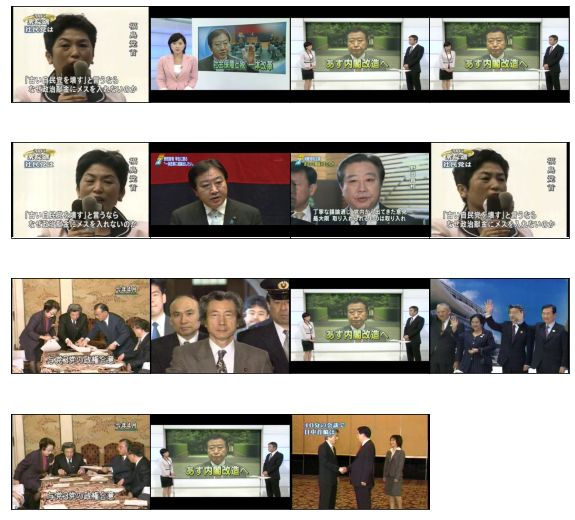

In [7]:
def grid_images(img_list):
    n = len(img_list)
    nrows, ncols = round(n**0.5), int((n-1)/round(n**0.5)+1)
    _, axes = plt.subplots(nrows, ncols, figsize=(10,10))
    for i,img in enumerate(img_list):
        axes[i%nrows, i//ncols].imshow(img)
        axes[i%nrows, i//ncols].get_xaxis().set_visible(False)
        axes[i%nrows, i//ncols].get_yaxis().set_visible(False)
    [axes.flat[-1].set_visible(False) for _ in range(nrows*ncols - i)]
    plt.subplots_adjust(wspace=0, hspace=0)


img_list = [mpimg.imread(f'{img_dir}{img_name}.jpg') for img_name in image_names]
grid_images(img_list)

In [8]:
# Setup detector
import face_detection as fd
detector = fd.build_detector("DSFDDetector", confidence_threshold=.5, nms_iou_threshold=.3)

/home/emili/anaconda3/envs/gender_recognition/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


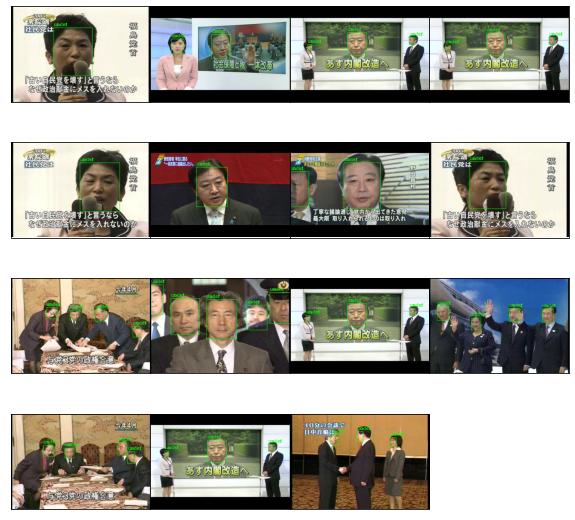

In [10]:
# Detector results
ann_list, ann_img_list, faces = [], [], []
for img_name in image_names:
    img_path = f'{img_dir}{img_name}.jpg'
    img = cv2.imread(img_path)[:, :, ::-1]
    ann = detect(img, detector)
    ann_img = utils.draw_annotation(img_path, annotations=ann)
    ann_list.append(ann)
    ann_img_list.append(ann_img[:, :, ::-1])
    # Crop faces using the bounding boxes
    for bbox in ann["bbox"]:
        face = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        if face.shape[0] and face.shape[1]:
            faces.append(face)
grid_images(ann_img_list)

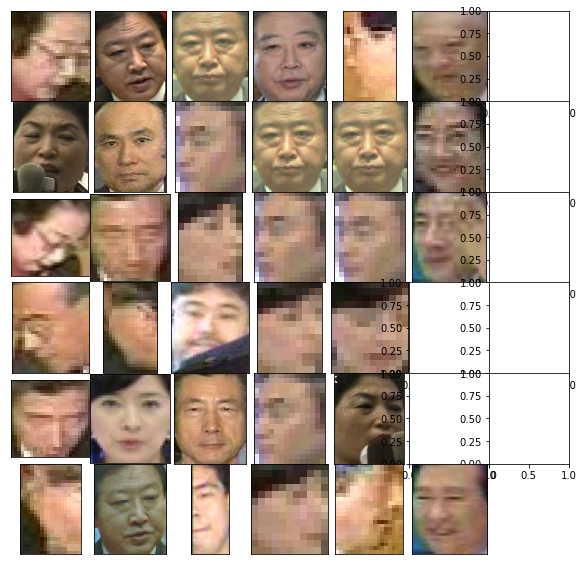

In [9]:
grid_images(faces)

# Approach 1: “Face Gender Recognition based on Recognition Feature Vectors“

In [12]:
import dlib
# !wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [13]:
# Load facial feature extraction model
# !bunzip2 ./shape_predictor_68_face_landmarks.dat.bz2
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

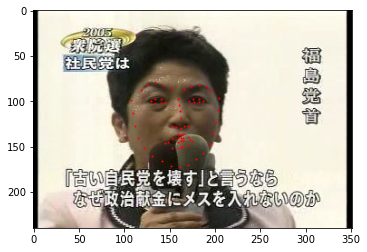

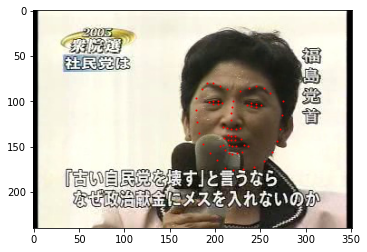

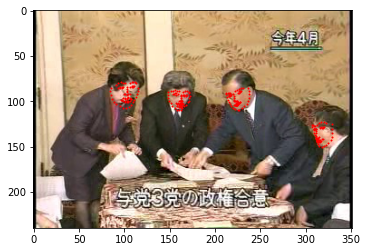

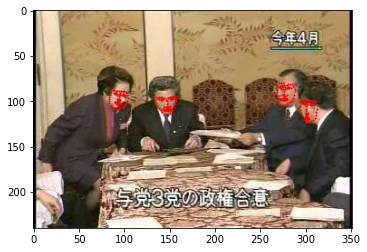

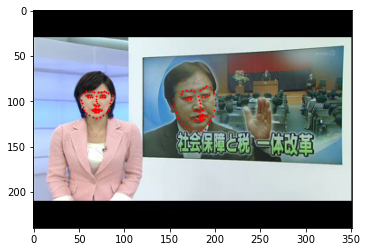

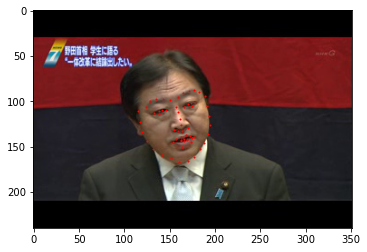

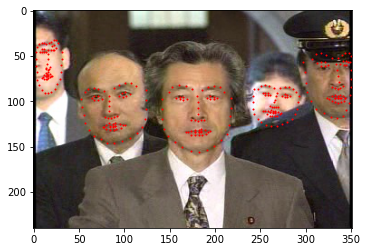

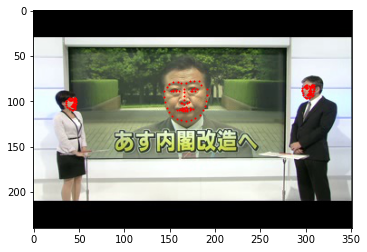

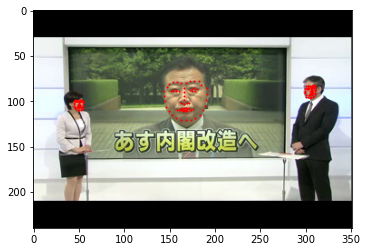

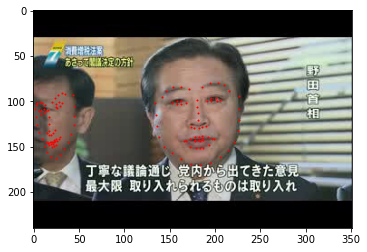

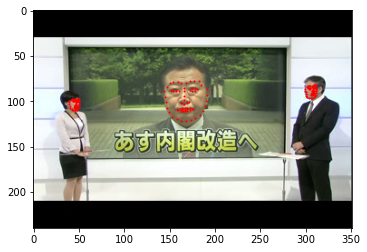

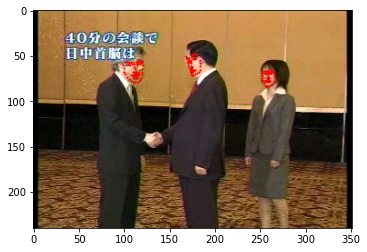

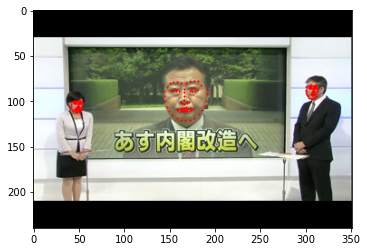

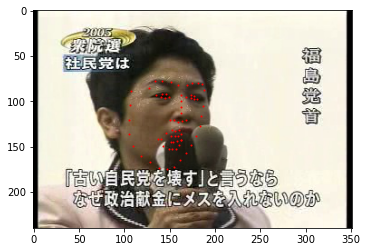

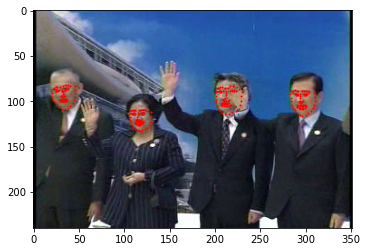

In [14]:
all_features = []
for i,img_name in enumerate(image_names):
    img = cv2.imread(f'{img_dir}{img_name}.jpg')
    gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    img.shape
    img_feats = []
    for bbox in ann_list[i]["bbox"].values:
        dlib_bbox = dlib.rectangle(bbox[0], bbox[1], bbox[2], bbox[3])
        landmarks = predictor(image=gray, box=dlib_bbox)
        for j in range(68):
            x = landmarks.part(j).x
            y = landmarks.part(j).y
            img_feats.append((x,y))
    all_features.append(img_feats)

    # Draw a circle
    [plt.scatter(x, y, c="red", s=1) for x, y in img_feats]
    plt.imshow(img[:,:,::-1])
    plt.show()


/home/emili/anaconda3/envs/gender_recognition/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


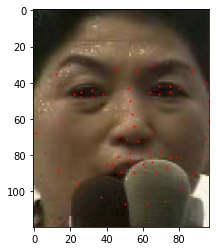

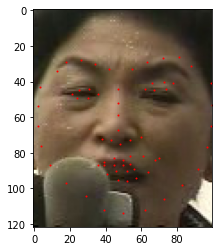

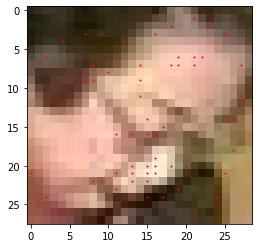

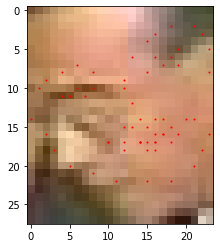

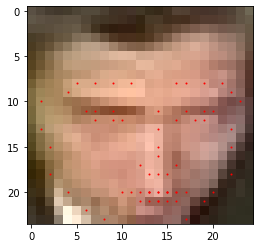

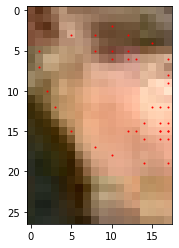

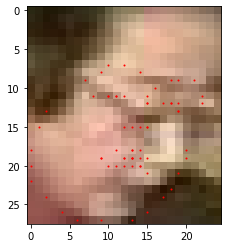

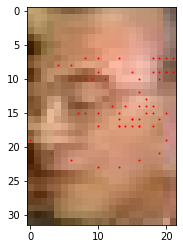

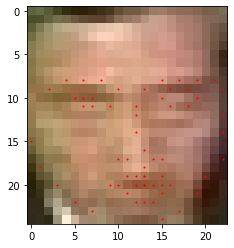

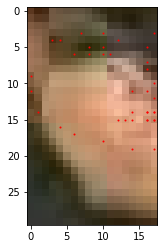

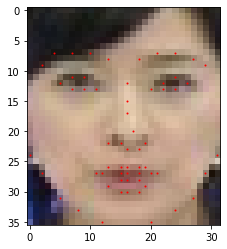

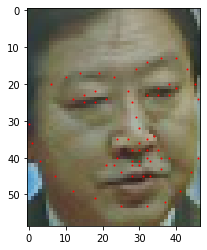

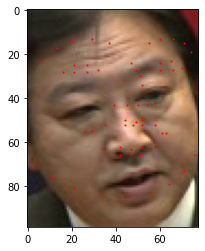

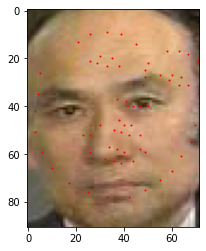

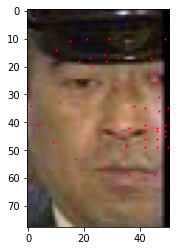

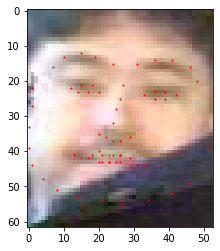

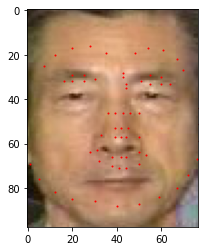

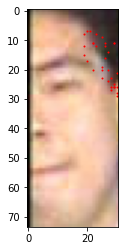

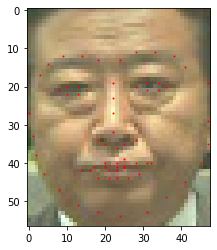

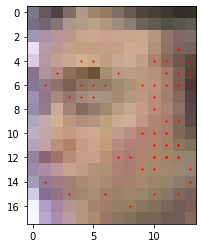

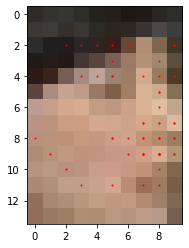

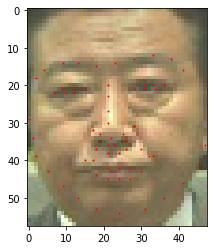

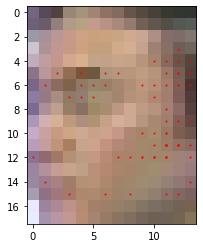

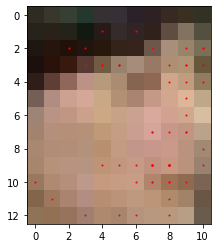

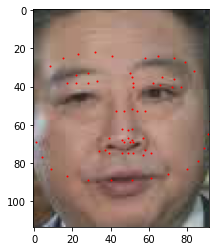

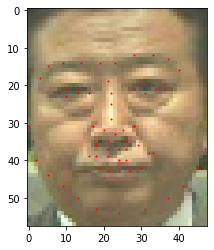

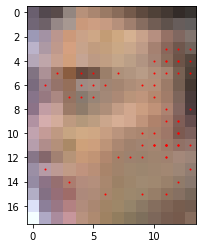

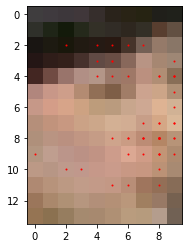

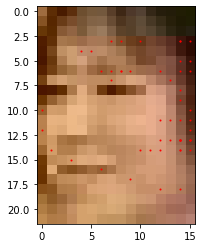

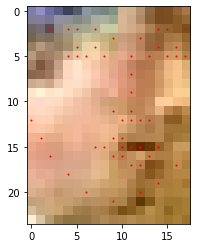

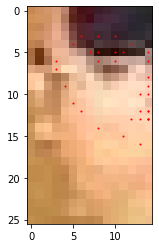

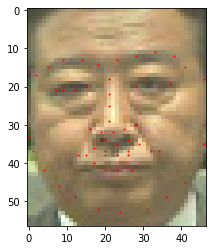

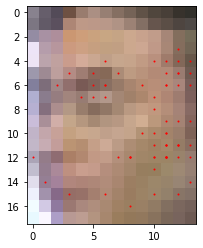

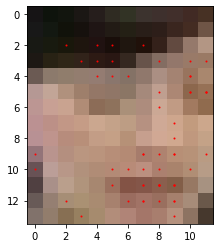

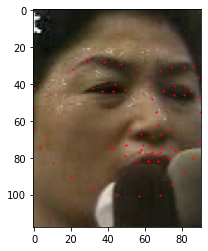

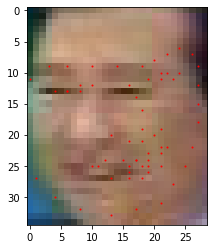

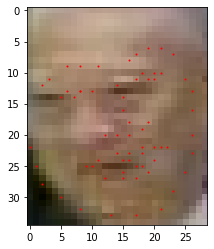

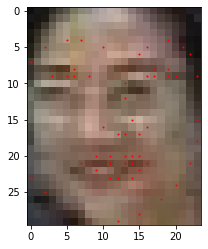

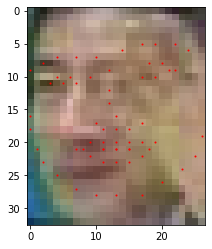

In [15]:
all_face_feats, landmarked_faces = [], []
for i,face in enumerate(faces):
    gray = cv2.cvtColor(src=face, code=cv2.COLOR_BGR2GRAY)
    dlib_bbox = dlib.rectangle(0, 0, gray.shape[0], gray.shape[1])
    landmarks = predictor(image=gray, box=dlib_bbox)
    face_feats = []
    for j in range(68):
        x = landmarks.part(j).x
        y = landmarks.part(j).y
        face_feats.append((x,y))
    all_features.append(face_feats)

    # Draw a circle
    fig = plt.figure()
    [plt.scatter(x, y, c="red", s=1) for x, y in face_feats]
    plt.imshow(face)